In [1]:
import csv
import numpy as np
import pandas as pd
import nltk

import re
from nltk.stem import WordNetLemmatizer
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.utils import class_weight 
from imblearn.over_sampling import SMOTE


from nltk import word_tokenize, FreqDist
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
import networkx as nx
from sklearn import preprocessing
#RNN
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten


#Exclude stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [2]:
!pip install emoji
import emoji
!pip install detect
!pip install langdetect
from langdetect import detect
!pip3 install textacy
#https://chartbeat-labs.github.io/textacy/build/html/api_reference/text_processing.html
import textacy
from textacy import preprocessing
from textacy import preprocess
#https://pypi.org/project/wordsegment/
!pip install wordsegment
from wordsegment import load, segment
load()

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=2dfaa6c45ea7299128934343b70400d034de794ed719e0a0b667d43f7badcf1c
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
  Created wheel for detect: filename=detect-2019.4.13-cp36-none-any.whl size=1936 sha256=2cf43cc85077ddf3300f389e0d3188135dcefe94f40359687056c96e82daca6f
  Stored in directory: /root/.cache/pip/wheels/39/c6/be/459c0fbc1e381ed5fd3c66eddec846589a00701ae5e996a1c7
Successfully built detect
     |████████████████████████████████| 983kB 2.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993193 sha256=b86177c93f88fb793f63928b9ac2932042723309ce1a79938599893aceb75c96
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
     |████████████████████

## Load Data

In [3]:
# Read test data
test_index = list()  
with open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/test.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        test_index.append(int(t[0]))
# Load the textual content of the messages into the dictionary "posts"
posts = dict()
posted_by = dict()
posts_per_class = dict()
with open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/posts.tsv', 'r', encoding ='utf-8') as f:
    for line in f:
        t = line.split('\t')
        posts[int(t[0])] = t[2][:-1]
        posted_by[int(t[0])] = int(t[1])
        posts_per_class[int(t[1])] = np.zeros(15)
users = dict()
posts_per_user = dict()
with open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/users.csv', 'r', encoding ='utf-8') as f:
    for line in f.readlines()[1:]:
        t = line.split(',')
        users[int(t[0])] = t[0]
        posts_per_user[int(t[0])] = int(t[3][:-1])
y_data = dict()    
with open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/train.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        y_data[int(t[0])] = int(t[1])
        posts_per_class[posted_by[int(t[0])]][int(t[1][:-1])] += 1
train_index = list(y_data.keys())
y_train_input =list(y_data.values())                

## Data Preprocess

In [ ]:
stemmer = WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
twitter_posts = dict()
twitter_posts_zero_len =dict()
# stop_words = set(stopwords.words('english')) 
stop_words = set(stopwords.words()) 
for sen in range(0, len(posts)): 

    # Removing http
    post = re.sub(r"http\S+", "", str(posts[sen]))

    #convert emoji to word
    post = emoji.demojize(post)

    post=textacy.preprocessing.normalize_whitespace(post)
# 2nd run
    post=textacy.preprocessing.normalize_quotation_marks(post)

    post=textacy.preprocess.unpack_contractions(post)
# #

    post=textacy.preprocessing.normalize_unicode(post, form=u'NFKC')

    post=textacy.preprocessing.remove.remove_punctuation(post)

    post=textacy.preprocessing.remove.remove_accents(post)

    post=textacy.preprocessing.replace.replace_currency_symbols(post)

    post=textacy.preprocessing.replace.replace_emails(post)

    post=textacy.preprocessing.replace.replace_hashtags(post)

    post=textacy.preprocessing.replace.replace_numbers(post)

    post=textacy.preprocessing.replace.replace_phone_numbers(post)

    post=textacy.preprocessing.replace.replace_urls(post)

    post=textacy.preprocessing.replace.replace_user_handles(post)
    
#     # # Remove &amp;
    post = re.sub(r'&gt;|&lt;|&amp;', '', post)   
    
#     # #remove hashtag, @user, link of a tweet using regular expression
    post = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",' ',post) 


    # # Remove all the special characters
    post = re.sub(r'\W', ' ', post)

    # # # remove all single characters
    post = re.sub(r'\s+[a-zA-Z]\s+', ' ', post)

    # # # Remove single characters from the start
    post = re.sub(r'\^[a-zA-Z]\s+', ' ', post) 

    # # # Substituting multiple spaces with single space
    post = re.sub(r'\s+', ' ', post, flags=re.I)

    # # # Removing prefixed 'b'
    post = re.sub(r'^b\s+', '', post)
    
    post = re.sub(r'[^\x00-\x7f]','', post) 
    
    # Removing numbers
    post = re.sub(r'\d+', '', post)
    
    # # Converting to Lowercase
    post = post.lower()

    # # Remove &amp;
    # # post = re.sub(r'covid|coronavirus|pandemic|help|people', '', post)     

    
    # # Lemmatization
    post = w_tokenizer.tokenize((post))
    
    # 3rd run
    post = segment(post)

    post = [stemmer.lemmatize(word) for word in post if not word in stop_words]

    if (len(post) > 0) or (sen in (test_index)):
        post = ' '.join(post)
        twitter_posts[sen] = post
        
            # 3rd run
        twitter_posts[sen] = segment(twitter_posts[sen])

        twitter_posts[sen] = ' '.join(map(str, twitter_posts[sen]))

    else:
        post = ' '.join(post)
        twitter_posts_zero_len[sen] = post
print(posts[0])
print()
print(twitter_posts[0])

Due to huge computational execution time of the segment function, we create the below file.

In [6]:
twitter_posts = dict() 
with open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/twitter_posts.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        twitter_posts[int(t[0])] = t[1][:-1]
twitter_posts_zero_len =dict()
twitter_posts_zero_len[4186]=''
twitter_posts_zero_len[12054]=''
#delete emtpy twitter posts
for i in twitter_posts_zero_len.keys():
    if i in (y_data.keys()):
        del y_data[i]
train_index = list(y_data.keys())
y_train_input =list(y_data.values())

In [7]:
twitter_posts[1]

'read news one pk donald trump vladimir putin coronavirus outbreak coronavirus corona outbreak covid19'

## Text features

In [8]:
train_posts = [twitter_posts[idx] for idx in train_index  ]
test_posts = [twitter_posts[idx] for idx in test_index ]
vectorizer = TfidfVectorizer(ngram_range=(1,3),  max_features = 12000,sublinear_tf=True,min_df = 0.00005,max_df = 0.85, stop_words=stopwords.words('english'))

X_train_input = vectorizer.fit_transform(train_posts)

X_test_final = vectorizer.transform(test_posts)

print("Train matrix dimensionality: ", X_train_input.shape)
print("Test matrix dimensionality: ", X_test_final.shape)

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X_train_input, y_train_input, test_size=0.25, random_state=23828748)
categories = [str(x) for x in np.arange(0, 15, 1)]

Train matrix dimensionality:  (13219, 12000)
Test matrix dimensionality:  (3306, 12000)


## Graph

In [9]:
import networkx as nx

# Load the processsed retweet network as an undirected graph
G = nx.read_weighted_edgelist("/content/drive/My Drive/Colab Notebooks/DataChallenge/data/retweet_processed_weighted.edgelist", create_using=nx.Graph(), nodetype=int)
nodes = set(G.nodes())
for user in users:
    if user not in nodes:
        G.add_node(user)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 12640
Number of edges: 1356575


Due to huge computational execution time of the below metrics, we create the below files using the graph of file retweet_weighted.

In [10]:
closeness_centrality = dict()    
with open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/closeness_centrality.csv', 'r') as f:
   for line in f:
        t = line.split(',')
        closeness_centrality[int(t[0])] = t[1][:-1]

In [11]:
# betweenness_centrality = nx.betweenness_centrality(G,k=1000)
# with open('betweenness_centrality.csv', 'w') as f:

#    for k, v in betweenness_centrality.items():
#         f.write(str(k) + ','+ str(v) + '\n')

betweenness_centrality = dict() 
with open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/betweenness_centrality.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        betweenness_centrality[int(t[0])] = t[1][:-1]

In [12]:
#pr = nx.pagerank(G, alpha=0.85)

#with open('pagerank.csv', 'w') as f:

#    for k, v in pr.items():
#         f.write(str(k) + ','+ str(v) + '\n')

page_rank = dict() 
with open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/pagerank.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        page_rank[int(t[0])] = t[1][:-1]

In [13]:
from community_louvain import best_partition

partition = best_partition(G)
communities = set(partition.values())
n_communities = len(communities)
print('Number of communities:', n_communities)

Number of communities: 1414


#### Create graph features Degree, Partition, Posts per Class, Page Rank, Closeness Centrality and length of each tweet

In [14]:
# Create the training matrix
X_train_graph = np.zeros((len(train_index), 20))
for i,idx in enumerate(train_index):
    for neighbor in G.neighbors(posted_by[idx]):
        if partition[neighbor] == partition[posted_by[idx]]:
            X_train_graph[i,:15] += posts_per_class[neighbor]

    if np.sum(X_train_graph[i,:15]) > 0:
        X_train_graph[i,:15] /= np.sum(X_train_graph[i,:15])

    X_train_graph[i,15] = G.degree(posted_by[idx])
    X_train_graph[i,16] = partition[posted_by[idx]]
    X_train_graph[i,17] = page_rank[posted_by[idx]]
    X_train_graph[i,18] = closeness_centrality[posted_by[idx]]
    X_train_graph[i,19] = len(twitter_posts[idx])

# Create the test matrix 
X_test_graph = np.zeros((len(test_index), 20))
for i,idx in enumerate(test_index):
    for neighbor in G.neighbors(posted_by[idx]):
        if partition[neighbor] == partition[posted_by[idx]]:
            X_test_graph[i,:15] += posts_per_class[neighbor]

    if np.sum(X_test_graph[i,:15]) > 0:
        X_test_graph[i,:15] /= np.sum(X_test_graph[i,:15])

    X_test_graph[i,15] = G.degree(posted_by[idx])
    X_test_graph[i,16] = partition[posted_by[idx]]
    X_test_graph[i,17] = page_rank[posted_by[idx]]
    X_test_graph[i,18] = closeness_centrality[posted_by[idx]]
    X_test_graph[i,19] = len(twitter_posts[idx])
    
print("Train matrix dimensionality: ", X_train_graph.shape)
print("Test matrix dimensionality: ", X_test_graph.shape)

Train matrix dimensionality:  (13219, 20)
Test matrix dimensionality:  (3306, 20)


## Deep Walk

In [15]:
from random import randint

def random_walk(G, node, walk_length):
    # Starts from vertex "node" and performs a random walk of length "walk length". Returns a list of the visited vertices
    walk = [node]
    
    for i in range(walk_length-1):
        neighbors = list(G.neighbors(walk[-1]))
        if len(neighbors) > 0:
            next_node = neighbors[randint(0, len(neighbors)-1)]
            walk.append(next_node)
        else:
            break

    walk = [str(node) for node in walk]
    return walk

In [16]:
def generate_walks(graph, num_walks, walk_length):
    # Runs "num_walks" random walks from each node, and returns a list of all random walk
    walks = []
    
    for i in range(num_walks):
        for node in graph.nodes():
            walks.append(random_walk(graph, node, walk_length))

    return walks

In [17]:
# walks = generate_walks(G, 10, 10) 71.10%
walks = generate_walks(G, 20, 20) #71.47%
# walks = generate_walks(G, 30, 30)  #71.26%


In [18]:
from gensim.models import Word2Vec
model = Word2Vec(size=128, window=5, min_count=0, sg=1, workers=8)
model.build_vocab(walks)
model.train(walks, total_examples=model.corpus_count, epochs=10)

(45703600, 45703600)

In [19]:
X_train_walks = np.zeros((len(train_index), 128))
for i,idx in enumerate(train_index):
    X_train_walks[i,:] = model.wv[str(posted_by[idx])]
    

X_test_walks = np.zeros((len(test_index), 128))
for i,idx in enumerate(test_index):
    X_test_walks[i,:] = model.wv[str(posted_by[idx])]
    
print("Dimensionality of training matrix:", X_train_walks.shape)
print("Dimensionality of test matrix:", X_test_walks.shape)

Dimensionality of training matrix: (13219, 128)
Dimensionality of test matrix: (3306, 128)


## Graph of words with Grakel

In [20]:
!pip install grakel

     |████████████████████████████████| 1.7MB 2.6MB/s 
     |████████████████████████████████| 163kB 19.0MB/s 


Get Vocabulary

In [21]:
def get_vocab(twitter_posts):
    vocab = dict()
    
    for idx in train_index:
      sent = twitter_posts[idx]
      for word in (sent.split(' ')):
        if word not in vocab:
          vocab[word] = len(vocab)

    for idx in test_index:
      sent = twitter_posts[idx]
      for word in (sent.split(' ')):
          if word not in vocab:
              vocab[word] = len(vocab)
        
    return vocab


In [22]:
# Extract vocabulary
vocab = get_vocab(twitter_posts)
print("Size of vocabulary:", len(vocab))
print("Index of term 'covid'", vocab['covid'])

Size of vocabulary: 30103
Index of term 'covid' 220


In [23]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

def create_graphs_of_words(docs, vocab, window_size):
    graphs = list()
    sizes = list()
    degs = list()

    for idx,doc in enumerate(docs):
        G = nx.Graph()
      
        for i in range(len(doc)):
            if doc[i] not in G.nodes():
                G.add_node(doc[i])
                G.nodes[doc[i]]['label'] = vocab[doc[i]]
        for i in range(len(doc)):
            for j in range(i+1, i+window_size):
                if j < len(doc):
                    G.add_edge(doc[i], doc[j])
        
        graphs.append(G)
    
    return graphs

In [24]:
train_docs = []
test_docs = []
for idx in train_index:
  sent = twitter_posts[idx].split(' ')
  train_docs.append(sent)
for idx in test_index:
  sent = twitter_posts[idx].split(' ')
  test_docs.append(sent)
# Create graph-of-words representations
G_train_nx = create_graphs_of_words(train_docs, vocab, 3)
G_test_nx = create_graphs_of_words(test_docs, vocab, 3)

Example of graph-of-words representation of document


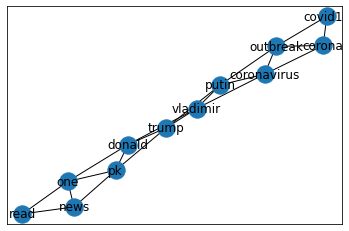

In [25]:
print("Example of graph-of-words representation of document")
nx.draw_networkx(G_train_nx[1], with_labels=True)

In [26]:
from grakel.utils import graph_from_networkx
from grakel.kernels import WeisfeilerLehman, VertexHistogram, RandomWalkLabeled,NeighborhoodHash
# Transform networkx graphs to grakel representations
G_train = list(graph_from_networkx(G_train_nx, node_labels_tag='label'))
G_test= list(graph_from_networkx(G_test_nx, node_labels_tag='label'))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [28]:


from sklearn.model_selection import train_test_split  
X_train_nx, X_test_nx, y_train_nx, y_test_nx = train_test_split(G_train, y_train_input, test_size=0.25, random_state=23828748)

# Initialize a Weisfeiler-Lehman subtree kernel
gk = WeisfeilerLehman(n_iter=1, normalize=True)
# Construct kernel matrices
K_train = gk.fit_transform(X_train_nx)
K_test = gk.transform(X_test_nx)

In [29]:
# Train an SVM classifier and make predictions
from sklearn import svm
clf = svm.SVC(kernel='precomputed')
clf.fit(K_train, y_train) 
y_pred = clf.predict(K_test)

# Evaluate the predictions
print("Accuracy:", accuracy_score(y_pred, y_test_nx))

Accuracy: 0.6529500756429653


## Pretrained Word Embeddings

In [30]:
GLOVE_DIM = 50
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt')
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

### Word 2 Vec Feature

In [31]:
# tfidf_feat = vectorizer.get_feature_names()
train_w2v =[];
row=0;
for idx in train_index:
  sent_vec = np.zeros(50)
  sent = twitter_posts[idx]
  weight_sum =0;
  for word in (sent.split(' ')):
    if  word in emb_dict.keys():      
      vec = emb_dict[word]
      sent_vec += vec
    # sent_vec/=weight_sum
  train_w2v.append(sent_vec)

  row +=1      

In [32]:
# tfidf_feat = vectorizer.get_feature_names()
test_w2v =[];
row=0;
for idx in test_index:
  sent_vec = np.zeros(50)
  sent = twitter_posts[idx]
  weight_sum =0;
  for word in (sent.split(' ')):
    if  word in emb_dict.keys():      
      vec = emb_dict[word]
      sent_vec += vec
    # sent_vec/=weight_sum
  test_w2v.append(sent_vec)

  row +=1      

In [33]:
from sklearn.preprocessing import Normalizer

train_w2v = Normalizer().fit_transform(train_w2v)
test_w2v = Normalizer().fit_transform(test_w2v)

In [34]:
X_train_input_final = csr_matrix(hstack([X_train_input,X_train_graph,X_train_walks,train_w2v]))
X_kaggle = csr_matrix(hstack([X_test_final,X_test_graph,X_test_walks,test_w2v]))

In [35]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X_train_input_final, y_train_input, test_size=0.25, random_state=23828748)
categories = [str(x) for x in np.arange(0, 15, 1)]

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(solver="liblinear", C=5, max_iter=200)
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)
score = f1_score(y_train,predictions,average='micro')
print("train f1-score: %.2f%%"%(score*100))

predictions_test = clf.predict(X_test)
score = f1_score(y_test, predictions_test,average='micro')
print("test f1-score: %.2f%%"%(score*100))
print()
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
print(pd.crosstab(y_true, y_pred))
print(classification_report(y_true, y_pred,target_names=categories))


train f1-score: 92.22%
test f1-score: 70.86%

test data confusion matrix
Predicted    0   1    2    3    4   5   6   8   9   10  11  12  13  14
True                                                                  
0          1177   6   92   43   40   1   0   1   1   5  11   4   2   6
1            24  84   32    5    5   1   0   0   0   3   0   1   1   0
2           126  10  420    5    5   2   1   0   0   9   2   6   0   0
3            56   2    6  278    2   0   0   2   0   0   0   3   0   0
4            93   3   13    2  138   0   0   1   0   5   2   0   0   1
5             5   0    5    1    0  41   0   0   0   1   0   0   0   0
6             9   3    6    2    1   0   5   0   0   2   0   0   0   0
7             5   0    1    0    0   0   0   0   0   0   0   0   0   0
8            11   2    0    2    1   0   0   6   0   0   0   0   0   0
9            14   2    3    0    1   0   0   0   9   0   1   0   0   0
10           42   6   41    2    6   0   0   0   0  21   1   2   1   0
11  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Word 2 Vec with TF-IDF

In [47]:
model = TfidfVectorizer()
model.fit(train_posts)
dictionary = dict(zip(model.get_feature_names(),list(model.idf_)))

In [48]:
tfidf_feat = vectorizer.get_feature_names()
train_w2v_tfidf =[];
row=0;
for idx in train_index:
  sent_vec = np.zeros(50)
  sent = twitter_posts[idx]
  weight_sum =0;
  for word in (sent.split(' ')):
    if  word in emb_dict.keys() and word in tfidf_feat:      
      vec = emb_dict[word]
      tf_idf =  dictionary[word]*sent.split(' ').count(word)/len(sent.split(' '))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
  if weight_sum != 0 :
    # sent_vec/=weight_sum
    train_w2v_tfidf.append(sent_vec/weight_sum)
  else:
    train_w2v_tfidf.append(np.zeros(50)  )
  row +=1      

In [49]:
tfidf_feat = vectorizer.get_feature_names()
test_w2v_tfidf =[];
row=0;
for idx in test_index:
  sent_vec = np.zeros(50)
  sent = twitter_posts[idx]
  weight_sum =0;
  for word in (sent.split(' ')):
    if  word in emb_dict.keys() and word in tfidf_feat:      
      vec = emb_dict[word]
      tf_idf = dictionary[word]*sent.split(' ').count(word)/len(sent.split(' '))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
  if weight_sum != 0 :
    # sent_vec/=weight_sum
    test_w2v_tfidf.append(sent_vec/weight_sum)
  else:
    test_w2v_tfidf.append(np.zeros(50))
  row +=1       

Normalize Feature

In [50]:
from sklearn.preprocessing import Normalizer

train_w2v_tfidf_norm = Normalizer().fit_transform(train_w2v_tfidf)
test_w2v_tfidf_norm = Normalizer().fit_transform(test_w2v_tfidf)

X_train_graph_norm = Normalizer().fit_transform(X_train_graph)
X_test_graph_norm = Normalizer().fit_transform(X_test_graph)

X_train_walks_norm = Normalizer().fit_transform(X_train_walks)
X_test_walks_norm = Normalizer().fit_transform(X_test_walks)


In [51]:
train_posts = [twitter_posts[idx] for idx in train_index  ]
test_posts = [twitter_posts[idx] for idx in test_index ]
# vectorizer = TfidfVectorizer(ngram_range=(1,2),  max_features = 7000,sublinear_tf=True,min_df = 0.00005,max_df = 0.85, stop_words=stopwords.words('english'))
vectorizer = TfidfVectorizer(ngram_range=(1,3),  max_features = 12000,sublinear_tf=True,min_df = 0.00005,max_df = 0.85, stop_words=stopwords.words('english'))

X_train_input = vectorizer.fit_transform(train_posts)

X_test_final = vectorizer.transform(test_posts)

print("Train matrix dimensionality: ", X_train_input.shape)
print("Test matrix dimensionality: ", X_test_final.shape)


Train matrix dimensionality:  (13219, 12000)
Test matrix dimensionality:  (3306, 12000)


In [ ]:
# gk = WeisfeilerLehman(n_iter=1, normalize=True)
# K_train = gk.fit_transform(G_train)
# K_test_final = gk.transform(G_test)

In [52]:
X_train_input_final = csr_matrix(hstack([X_train_input,X_train_graph_norm,X_train_walks_norm,train_w2v_tfidf_norm]))
X_kaggle = csr_matrix(hstack([X_test_final,X_test_graph_norm,X_test_walks_norm,test_w2v_tfidf_norm]))

In [53]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X_train_input_final, y_train_input, test_size=0.25, random_state=23828748)
categories = [str(x) for x in np.arange(0, 15, 1)]

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(solver="liblinear", C=5, max_iter=200)
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)
score = f1_score(y_train,predictions,average='micro')
print("train f1-score: %.2f%%"%(score*100))

predictions_test = clf.predict(X_test)
score = f1_score(y_test, predictions_test,average='micro')
print("test f1-score: %.2f%%"%(score*100))
print()
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
print(pd.crosstab(y_true, y_pred))
print(classification_report(y_true, y_pred,target_names=categories))


train f1-score: 92.96%
test f1-score: 70.65%

test data confusion matrix
Predicted    0   1    2    3    4   5   6   8   9   10  11  12  13  14
True                                                                  
0          1196   3   89   36   41   0   0   0   1   4   9   4   2   4
1            31  77   30    7    3   1   0   0   0   4   0   2   1   0
2           125   8  427    6    5   0   0   0   1   5   3   6   0   0
3            55   2    4  282    3   0   0   0   0   1   0   2   0   0
4            93   1   15    3  136   0   0   0   0   6   2   0   0   2
5             8   0    6    0    0  39   0   0   0   0   0   0   0   0
6            12   3    5    2    1   0   4   0   0   1   0   0   0   0
7             6   0    0    0    0   0   0   0   0   0   0   0   0   0
8            12   2    0    3    0   0   0   5   0   0   0   0   0   0
9            18   1    2    0    0   0   0   0   8   0   1   0   0   0
10           46   5   41    2    4   0   0   0   0  21   1   1   0   1
11  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Train my own Word Embeddings

In [37]:
i=0
list_of_sentences = []
for sen in range(0, len(posts)): 
  sentence = str(posts[sen])
  list_of_sentences.append(sentence.split())

In [38]:
from gensim.models import Word2Vec  
w2v_model = Word2Vec(list_of_sentences,size=50,window=10,min_count=5,workers=4)

In [39]:
w2v_words = list(w2v_model.wv.vocab)

In [ ]:
model = TfidfVectorizer()
model.fit(train_posts)
dictionary = dict(zip(model.get_feature_names(),list(model.idf_)))

In [42]:
tfidf_feat = vectorizer.get_feature_names()
train_w2v_tfidf =[];
row=0;
for idx in train_index:
  sent_vec = np.zeros(50)
  sent = twitter_posts[idx]
  weight_sum =0;
  for word in (sent.split(' ')):
    if  word in w2v_words and word in tfidf_feat:      
      vec = w2v_model.wv[word]
      tf_idf =  dictionary[word]*sent.count(word)/len(sent)
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
  if weight_sum != 0 :
    # sent_vec/=weight_sum
    train_w2v_tfidf.append(sent_vec/weight_sum)
  else:
    train_w2v_tfidf.append(np.zeros(50))
  row +=1      

In [43]:
tfidf_feat = vectorizer.get_feature_names()
test_w2v_tfidf =[];
row=0;
for idx in test_index:
  sent_vec = np.zeros(50)
  sent = twitter_posts[idx]
  weight_sum =0;
  for word in (sent.split(' ')):
    if  word in w2v_words and word in tfidf_feat:      
      vec = w2v_model.wv[word]
      tf_idf =  dictionary[word]*sent.count(word)/len(sent)
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
  if weight_sum != 0 :
    # sent_vec/=weight_sum
    test_w2v_tfidf.append(sent_vec/weight_sum)
  else:
    test_w2v_tfidf.append(np.zeros(50))
  row +=1      

In [44]:
from sklearn.preprocessing import Normalizer

train_w2v_tfidf = Normalizer().fit_transform(train_w2v_tfidf)
test_w2v_tfidf = Normalizer().fit_transform(test_w2v_tfidf)


In [45]:
X_train_input_final = csr_matrix(hstack([X_train_input,X_train_graph,X_train_walks,train_w2v_tfidf]))
X_kaggle = csr_matrix(hstack([X_test_final,X_test_graph,X_test_walks,test_w2v_tfidf]))

In [46]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(X_train_input_final, y_train_input, test_size=0.25, random_state=23828748)
categories = [str(x) for x in np.arange(0, 15, 1)]

### Smote and class weights

In [55]:
categories = [str(x) for x in np.arange(0, 15, 1)]


weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)


class_w = dict()
for i in range(0, len(weights)):
    class_w[i] = weights[i]
smote = SMOTE('minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)
print(X_train.shape,X_sm.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(9914, 12198) (14135, 12198)


## Algorithms

#### Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(solver="liblinear", C=5, max_iter=200)
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)
score = f1_score(y_train,predictions,average='micro')
print("train f1-score: %.2f%%"%(score*100))

predictions_test = clf.predict(X_test)
score = f1_score(y_test, predictions_test,average='micro')
print("test f1-score: %.2f%%"%(score*100))
print()
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
print(pd.crosstab(y_true, y_pred))
print(classification_report(y_true, y_pred,target_names=categories))


train f1-score: 92.96%
test f1-score: 70.65%

test data confusion matrix
Predicted    0   1    2    3    4   5   6   8   9   10  11  12  13  14
True                                                                  
0          1196   3   89   36   41   0   0   0   1   4   9   4   2   4
1            31  77   30    7    3   1   0   0   0   4   0   2   1   0
2           125   8  427    6    5   0   0   0   1   5   3   6   0   0
3            55   2    4  282    3   0   0   0   0   1   0   2   0   0
4            93   1   15    3  136   0   0   0   0   6   2   0   0   2
5             8   0    6    0    0  39   0   0   0   0   0   0   0   0
6            12   3    5    2    1   0   4   0   0   1   0   0   0   0
7             6   0    0    0    0   0   0   0   0   0   0   0   0   0
8            12   2    0    3    0   0   0   5   0   0   0   0   0   0
9            18   1    2    0    0   0   0   0   8   0   1   0   0   0
10           46   5   41    2    4   0   0   0   0  21   1   1   0   1
11  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Logistic Regression with class weights

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(solver="liblinear", C=6, max_iter=200,class_weight=class_w)
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)
score = f1_score(y_train,predictions,average='micro')
print("train f1-score: %.2f%%"%(score*100))

predictions_test = clf.predict(X_test)
score = f1_score(y_test, predictions_test,average='micro')
print("test f1-score: %.2f%%"%(score*100))
print()
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
print(pd.crosstab(y_true, y_pred))
print(classification_report(y_true, y_pred,target_names=categories))


train f1-score: 91.80%
test f1-score: 70.29%

test data confusion matrix
Predicted    0   1    2    3    4   5   6   7   8   9   10  11  12  13  14
True                                                                      
0          1047  15   96   58   81   1   2   0   6   4  18  19  11   6  25
1            14  95   22    6    2   1   1   0   0   2   7   0   5   1   0
2            82  14  417    7   14   1   2   1   3   1  19   7  15   2   1
3            25   4    1  302    3   0   1   0   4   0   4   0   3   1   1
4            51   1   11    4  166   0   0   0   1   0  13   3   2   1   5
5             6   0    3    0    0  41   0   0   0   0   2   0   1   0   0
6             5   2    4    2    2   1   9   0   0   0   2   0   0   1   0
7             4   1    0    0    1   0   0   0   0   0   0   0   0   0   0
8             6   3    0    3    1   0   0   0   8   0   1   0   0   0   0
9            11   1    2    0    1   0   0   0   0  14   0   1   0   0   0
10           24   8   39   

#### Logistic Regression with class weights and Smote

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(solver="lbfgs", C=5, max_iter=800, class_weight=class_w)
clf.fit(X_sm, y_sm)
predictions = clf.predict(X_sm)
score = f1_score(y_sm,predictions,average='micro')
print("train f1-score: %.2f%%"%(score*100))

predictions_test = clf.predict(X_test)
score = f1_score(y_test, predictions_test,average='micro')
print("test f1-score: %.2f%%"%(score*100))
print()
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
print(pd.crosstab(y_true, y_pred))
print(classification_report(y_true, y_pred,target_names=categories))


train f1-score: 91.03%
test f1-score: 66.72%

test data confusion matrix
Predicted   0   1    2    3    4   5   6   7   8   9   10  11  12  13  14
True                                                                     
0          912  20  117   67  127   1   3   1  10  15  31  17  16   7  45
1           10  93   18    6    3   1   1   1   1   3   8   2   8   1   0
2           64  24  408    8   13   2   1   5   4   1  27   6  19   2   2
3           19   5    3  303    3   0   2   0   5   0   4   0   3   1   1
4           35   2    8    5  172   2   1   1   0   1  18   3   2   1   7
5            5   0    4    0    0  41   0   0   0   0   2   0   1   0   0
6            5   2    4    2    2   1   8   1   0   0   2   0   0   1   0
7            4   0    0    0    1   0   0   1   0   0   0   0   0   0   0
8            6   3    0    3    1   0   0   0   8   0   1   0   0   0   0
9            8   1    2    0    1   0   0   0   0  17   0   1   0   0   0
10          20   8   37    3    5   1  

#### Grid Search 

In [ ]:
from sklearn.model_selection import GridSearchCV
logistic = LogisticRegression(max_iter=200)
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10 ,100)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

#### SVM

In [59]:
from sklearn import svm
from sklearn.metrics import f1_score


clf = svm.SVC(C=1, break_ties=False, cache_size=200, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
clf.fit(X_train, y_train)
predictions = clf.predict(X_train)
score = f1_score(y_train,predictions,average='micro')
print("train f1-score: %.2f%%"%(score*100))

predictions_test = clf.predict(X_test)
score = f1_score(y_test, predictions_test,average='micro')
print("test f1-score: %.2f%%"%(score*100))
print()
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
pd.crosstab(y_true, y_pred)

train f1-score: 90.57%
test f1-score: 70.41%

test data confusion matrix


Predicted,0,1,2,3,4,5,6,8,9,10,11,12,13,14
True,,,,,,,,,,,,,,
0,1180,3,85,43,43,0,0,1,2,6,10,5,3,8
1,30,77,28,8,2,1,0,1,1,4,0,3,1,0
2,138,7,416,5,8,0,0,0,0,4,3,5,0,0
3,57,1,3,284,2,0,0,1,0,0,0,0,1,0
4,100,2,8,2,133,0,0,0,0,8,1,1,0,3
5,5,1,8,0,0,39,0,0,0,0,0,0,0,0
6,10,2,6,2,2,0,5,0,0,0,0,1,0,0
7,6,0,0,0,0,0,0,0,0,0,0,0,0,0
8,9,2,1,2,1,0,0,7,0,0,0,0,0,0


#### SVM with class weight and Smote

In [60]:
from sklearn import svm
from sklearn.metrics import f1_score


clf = svm.SVC(C=1, break_ties=False, cache_size=200, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear', class_weight=class_w,
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
clf.fit(X_sm, y_sm)
predictions = clf.predict(X_sm)
score = f1_score(y_sm,predictions,average='micro')
print("train f1-score: %.2f%%"%(score*100))

predictions_test = clf.predict(X_test)
score = f1_score(y_test, predictions_test,average='micro')
print("test f1-score: %.2f%%"%(score*100))
print()
print("test data confusion matrix")
y_true = pd.Series(y_test, name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
pd.crosstab(y_true, y_pred)

train f1-score: 88.23%
test f1-score: 65.81%

test data confusion matrix


Predicted,0,1,2,3,4,5,6,8,9,10,11,12,13,14
True,,,,,,,,,,,,,,
0,894,18,120,88,146,0,0,7,10,30,21,11,5,39
1,14,92,17,8,4,1,1,0,1,10,1,6,1,0
2,75,26,405,7,13,1,2,1,1,30,5,16,2,2
3,22,4,3,311,2,0,0,3,0,1,0,1,1,1
4,39,3,10,5,179,0,0,0,0,13,2,2,0,5
5,7,1,6,0,0,38,0,0,0,1,0,0,0,0
6,6,4,5,2,3,0,6,0,0,0,0,1,1,0
7,3,1,1,0,1,0,0,0,0,0,0,0,0,0
8,5,3,0,4,2,0,0,8,0,0,0,0,0,0


### Ensemble

In [61]:
svm_clf = svm.SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
log_clf = LogisticRegression(solver="liblinear", C=3.8, max_iter=200)

In [62]:
from sklearn.ensemble import  VotingClassifier

eclf1 = VotingClassifier(estimators=[('svm', svm_clf), ('logistic', log_clf)], voting='soft')

In [65]:
eclf1 = eclf1.fit(X_train, y_train)
predictions = eclf1.predict(X_train)
score = f1_score(y_train,predictions,average='micro')
print("train f1-score: %.2f%%"%(score*100))
predictions_test = eclf1.predict(X_test)
score = f1_score(y_test, predictions_test,average='micro')
print("test f1-score: %.2f%%"%(score*100))
print()

train f1-score: 95.90%
test f1-score: 71.32%



In [36]:
y_pred = eclf1.predict_proba(X_kaggle)

with open('VotingClassifier_submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = ['id']
    for i in range(15):
        lst.append('class_'+str(i))
    writer.writerow(lst)
    for i,idx in enumerate(test_index):
        lst = y_pred[i,:].tolist()
        lst.insert(0, idx)
        writer.writerow(lst)

#### Convolutional Neural Networks 

In [37]:
!pip3 install keras_tqdm

In [38]:
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import warnings

import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K


In [39]:
 def recall(y_true, y_pred):   
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

In [40]:
train_posts = [twitter_posts[idx] for idx in train_index  ]
test_posts = [twitter_posts[idx] for idx in test_index ]

In [41]:
# train_posts = [twitter_posts[idx] for idx in train_index]
# test_posts = [twitter_posts[idx] for idx in test_index]

from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(train_posts, y_train_input, test_size=0.25, random_state=23828748)

In [42]:

y_train_labels = tf.keras.utils.to_categorical(y_train, 15, dtype='float32')
y_test_labels = tf.keras.utils.to_categorical(y_test, 15, dtype='float32')
lb = LabelBinarizer()
ys = {'train': [], 'test': []}
ys['train'] = lb.fit_transform(list(map(str, y_train)))
ys['test'] = lb.transform(list(map(str, y_test)))
# Convert texts to sequence of indexes and PADDING
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_WORDS =10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_WORDS,oov_token='__UNK__')
tokenizer.fit_on_texts(X_train)
train_seqs = tokenizer.texts_to_sequences(X_train)
test_seqs = tokenizer.texts_to_sequences(X_test)
train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_final_seqs = tokenizer.texts_to_sequences(test_posts)
test_final_data = pad_sequences(test_final_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')


In [43]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22539 unique tokens.


In [44]:
GLOVE_DIM = 50
glove_file = 'glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
glove = open('/content/drive/My Drive/Colab Notebooks/DataChallenge/data/glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt')
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [45]:
emb_matrix = np.zeros((MAX_WORDS, GLOVE_DIM))
for w, i in tokenizer.word_index.items():
    if i < MAX_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
          emb_matrix[i] = vect
    else:
        break

In [46]:
#Create and train a CNN model with trigram filters

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K 



FILTERS = 128
KERNEL = 3
DENSE = 256
N_CLASSES = 15

# create empty sequential model
model = Sequential()
# add an embedding layer
model.add(Embedding(MAX_WORDS, GLOVE_DIM, weights=[emb_matrix], 
                    input_length=MAX_SEQUENCE_LENGTH, trainable=False))
# add 0.2 dropout probabillity
model.add(Dropout(0.2))
# add a convolution layer 
model.add(Conv1D(FILTERS, KERNEL, activation='relu', padding='valid'))
# max pooling with pool size=2
model.add(MaxPooling1D(2))
# add another convolution layer 
model.add(Conv1D(FILTERS, KERNEL, activation='relu', padding='valid'))
# max pooling
model.add(GlobalMaxPooling1D())
# add 0.2 dropout probabillity
model.add(Dropout(0.2))
# add dense layer
model.add(Dense( DENSE, activation='relu' ))
# add final linear layer
model.add(Dense( 15, activation='softmax'))

print(model.summary())
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_CNN_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model.fit(train_data, ys['train'],
              batch_size=32,
              epochs=50,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback(),callback],
              validation_data=(test_data, ys['test']),
              shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 98, 128)           19328     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 47, 128)           49280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              


Epoch 00001: val_f1 improved from -inf to 0.38515, saving model to keras_CNN_model



Epoch 00002: val_f1 improved from 0.38515 to 0.47974, saving model to keras_CNN_model



Epoch 00003: val_f1 improved from 0.47974 to 0.54301, saving model to keras_CNN_model



Epoch 00004: val_f1 improved from 0.54301 to 0.54679, saving model to keras_CNN_model



Epoch 00005: val_f1 improved from 0.54679 to 0.55296, saving model to keras_CNN_model



Epoch 00006: val_f1 improved from 0.55296 to 0.58274, saving model to keras_CNN_model



Epoch 00007: val_f1 improved from 0.58274 to 0.60338, saving model to keras_CNN_model



Epoch 00008: val_f1 did not improve from 0.60338



Epoch 00009: val_f1 did not improve from 0.60338



Epoch 00010: val_f1 improved from 0.60338 to 0.61473, saving model to keras_CNN_model



Epoch 00011: val_f1 did not improve from 0.61473



Epoch 00012: val_f1 improved from 0.61473 to 0.62977, saving model to keras_CNN_model



In [ ]:
y_pred = model.predict(test_final_data)

with open('cnn_1d.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = ['id']
    for i in range(15):
        lst.append('class_'+str(i))
    writer.writerow(lst)
    for i,idx in enumerate(test_index):
        lst = y_pred[i,:].tolist()
        lst.insert(0, idx)
        writer.writerow(lst)

### SVD

In [47]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=25,n_iter=7, random_state=42)
svd.fit(train_data)
train_svd = svd.transform(train_data)
print(train_svd)

[[ 1174.3255956    565.48792307  -580.3069264  ...   -22.99566022
     34.13083742    38.49463249]
 [ 4537.61396737   493.53853787 -1422.44287727 ...  -187.4424768
   -188.35734401  -211.22957472]
 [ 4023.01667105   842.3262946  -2146.20102344 ...   -78.60395416
    -44.36557171   -62.59172676]
 ...
 [ 3117.73405421  3418.24218915   413.35382348 ...    85.73087086
    -42.91545737   -56.41492597]
 [ 6292.26477857 -3586.65696723  2603.75302736 ...  2281.54956345
   1491.03576189   423.40452756]
 [ 5725.86779009 -1464.91318481  2065.95622946 ...   -55.01244206
   -336.04395537  -245.67418157]]


In [48]:
var_explained = svd.explained_variance_ratio_.sum()
var_explained 


0.9302808135774715

In [49]:

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=25,n_iter=7, random_state=42)
svd.fit(test_data)
test_svd = svd.transform(test_data)
print(test_svd)

[[ 2211.28384347 -1308.62753545   184.47639276 ... -1317.64396143
  -4704.16688162  -858.36535188]
 [ 7400.76208606  3650.17547531 -4222.35618714 ...  -182.4211498
    164.7438696   -149.66963055]
 [ 3829.96832183  1276.70701064 -1553.82207037 ...   614.45798759
   -139.41396657    27.90544625]
 ...
 [ 7326.04231924 -2366.97785649 -2951.9145602  ...   178.45000182
   -297.22361518  -577.30277348]
 [ 6790.55651617  4033.48269487  4431.67120903 ... -1855.57130596
   -769.8058856   -137.00324806]
 [ 1860.3274243    278.12108085   221.89952226 ...   115.08927121
     72.9377113    -10.65895456]]


In [50]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=25,n_iter=7, random_state=42)
svd.fit(test_final_data)
test_final_svd = svd.transform(test_final_data)
print(test_final_svd)

[[ 5946.3098353   1327.73800312  2853.08850722 ...  -570.2395607
    158.15741642  -434.69830469]
 [ 2444.90479385  2072.5709015    631.30323853 ...  3839.66872612
  -2680.50421689   697.67438419]
 [ 8139.39480669  1072.09604419   932.16730339 ...   226.29677311
   -404.64220939   956.46447813]
 ...
 [ 1890.82750042   810.96553183   788.2673383  ...  2356.01116708
  -1364.20911668   428.36385559]
 [ 1572.48251749   496.84857844 -1355.96506801 ...   -44.59947048
    136.45504852   -52.49904365]
 [ 1241.7404868    526.33556362   -87.38087458 ...  -200.55895033
     51.34510934   -43.0954279 ]]


In [51]:
from sklearn.preprocessing import Normalizer

In [52]:
# normalize the data attributes
normalized_train_svd = Normalizer().fit_transform(train_svd)
normalized_test_svd =  Normalizer().fit_transform(test_svd)
normalized_test_final_svd =  Normalizer().fit_transform(test_final_svd)

In [53]:
#Create and train a CNN model with trigram filters

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.optimizers import Adam
from keras import backend as K 



FILTERS = 128
KERNEL = 3
DENSE = 256
N_CLASSES = 15

# create empty sequential model
model = Sequential()
# add an embedding layer
model.add(Embedding(MAX_WORDS, GLOVE_DIM, weights=[emb_matrix], 
                    input_length=25, trainable=False))
# add 0.2 dropout probabillity
model.add(Dropout(0.2))
# add a convolution layer 
model.add(Conv1D(FILTERS, KERNEL, activation='relu', padding='valid'))
# max pooling with pool size=2
model.add(MaxPooling1D(2))
# add another convolution layer 
model.add(Conv1D(FILTERS, KERNEL, activation='relu', padding='valid'))
# max pooling
model.add(GlobalMaxPooling1D())
# add 0.2 dropout probabillity
model.add(Dropout(0.2))
# add dense layer
model.add(Dense( DENSE, activation='relu' ))
# add final linear layer
model.add(Dense( 15, activation='softmax'))

print(model.summary())
model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_CNN_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

model.fit(normalized_train_svd, ys['train'],
              batch_size=32,
              epochs=10,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback(),callback],
              validation_data=(normalized_test_svd, ys['test']),
              shuffle=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 50)            500000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 50)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 23, 128)           19328     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 128)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 9, 128)            49280     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)              


Epoch 00001: val_f1 did not improve from -inf



Epoch 00002: val_f1 did not improve from -inf



Epoch 00003: val_f1 did not improve from -inf



Epoch 00004: val_f1 did not improve from -inf



Epoch 00005: val_f1 did not improve from -inf



Epoch 00006: val_f1 did not improve from -inf

